# Notebook 4. Klastrowanie
Deadline dla grupy nr 1: 29.10, 23:59, deadline dla grupy nr 2: 30.10, 23:59

Importy, z szczególności nowa funkcjonalność, czyli `checker`.

In [2]:
import numpy as np
from typing import List, Tuple
from checker import checker

## Zadanie 1. Dane do Klastrowania (1 pkt.)
Pierwsze zadanie na rozgrzewkę to stworzenie datasetu do testowania późniejszych algorytmów klastrowania. Proszę zaimplementować poniższe kroki:
1. Wylosować 3 próbki danych z trzech różnych dwuwymiarowych rozkładów normalnych (*hint*: [`np.random.multivariate_normal`](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html)). Proszę użyć poniższych średnich i macierzy kowariancji i rozmiarów próbek.
2. Zestackować (*hint*: np. [`np.vstack`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html)) wylosowane próbki w jeden dataset.
3. Stworzyć wektor (jednowymiarowy array) z etykietami, oznaczającymi rozkład z którego została wylosowana dana próbka. Proszę użyć etykiet w postaci `int`, czyli `0, 1, 2`.
4. Wymieszać dane i etykiety (w ten sam sposób!), aby punkty z danego rozkładu nie były "po kolei", *hint*: [`np.random.permutation`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.permutation.html).

In [3]:
@checker(run_tests=True)
def sample_data(means: List[List[float]], 
                covs: List[np.ndarray], 
                sizes: List[int]) -> Tuple[np.ndarray, np.ndarray]:
    """Returns shuffled data sampled from different 2D Gaussians with labels"""
    X = [np.random.multivariate_normal(means[i], covs[i], size=sizes[i]) for i in range(len(means))]
    X = np.vstack(X)
    y = np.asarray([0] * sizes[0] + [1] * sizes[1] + [2] * sizes[2])
    perm = np.random.permutation(len(y))
    return X[perm], y[perm]

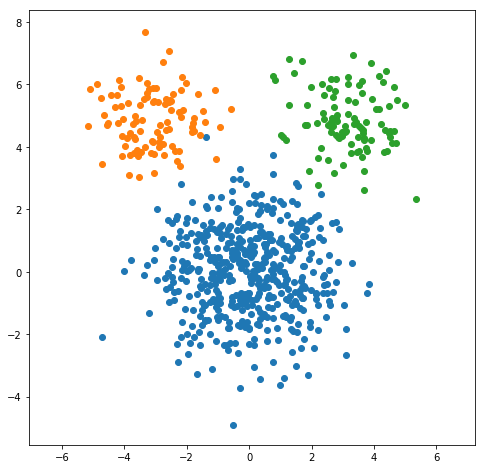

In [5]:
from utils import plot_clustering

means = [[0,0], [-3,5], [3,5]]

cov_1 = 2 * np.eye(2)
cov_2 = np.eye(2)
cov_3 = np.eye(2)
        
covs = [cov_1, cov_2, cov_3]

sizes = [500, 100, 100]

# sample data
X, y = sample_data(means, covs, sizes)
# plot the data
plot_clustering(X, y)

## Zadanie 2. K-Means (3 pkt.)

Zaimplementować algorytm K-Means. Kroki algorytmu znajdują się poniżej.


  0. Wylosuj k punktów z datasetu jako startowe średnie, do losowania proszę użyc [`np.random.choice`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.choice.html) uważając na domyślne parametry!
  1. Powtarzaj na zmianę poniższe dwa kroki:
      1. **Przypisanie do grupy:** Dla każdego punktu $x$, przypisz go do średniej $m_i$, która leży najbliżej euklidesowo do niego, czyli znajdź przyporządkowanie:
      $$ S_i = \{x: || x - m_i ||^2 \leq || x - m_j ||^2 \quad \forall j \} $$
      dla $i = 1, .., k$ - etykiety klastrów/grup.
      2. **Znalezienie nowych średnich:** Dla każdej grupy policzyć jej nową średnią:
      $$ m_i = \frac{1}{|S_i|} \sum_{j \in |S_i|} x_j $$
      
  2. Do momentu aż żaden z punktów nie zmieni swojego przyporządkowania w kroku A.

Państwa funkcja powinna zapisywać przydział do grup w każdej iteracji i zwracać listę przydziałów do grup z całego przebiegu algorytmu.


*hint:* do liczenia odległości użyć: [`scipy.spatial.distance.cdist`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist).

In [22]:
from scipy.spatial.distance import cdist

@checker(run_tests=False)
def k_means(X: np.ndarray, k: int) -> List[np.ndarray]:
    """
    Performs the k-means algorithm for dataset X with k clusters.
    X: 700x3
    """
    means = X[np.random.choice(range(len(X)), size=k, replace=False)]  # 3x2
    old_means = np.zeros(shape=(k, X.shape[1]))  # 3x2
    clusters = []
    while not np.isclose(old_means, means).all():
        distance = cdist(X, means)  # 700 x 3
        cluster = np.argmin(distance, axis=1)  # 700
        clusters.append(cluster)
        old_means = np.copy(means)
        for i in range(k):
            X_i = X[np.where(cluster == i)]
            if X_i.shape[0] > 0:
                means[i] = np.mean(X_i, axis=0)
            else:
                means[i] = X[np.random.choice(range(len(X)), size=1)]
    return clusters

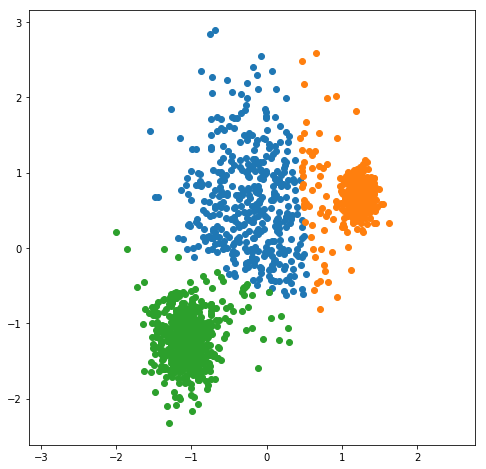

In [23]:
%matplotlib inline

# run k-means
ys = k_means(X, k=3)
# get final clustering
y = ys[-1]
# plot final clustering
plot_clustering(X, y)

In [10]:
# %matplotlib notebook
# from utils import animate_clustering

# # this seems really wonky, try multiple times if there's a warning about some callback
# animate_clustering(X, ys)

# Zadanie 3. Usprawnienia do K-Means (2 pkt.)

1. Ponieważ K-Means bardzo zależy od inicjalizacji (startowe losowe średnie), zmienić funkcje `k_means`, tak aby wykonywała algorytm `n_iters` razy i wybierała tę próbę, dla której *koszt* będzie najmniejszy?

**Pytanie:** jaki jest "koszt" algorytmu k-means?

In [24]:
from scipy.spatial.distance import cdist

@checker(run_tests=False)
def k_means_plus(X: np.ndarray, k: int, n_iters: int = 10) -> List[np.ndarray]:
    """Performs the k-means algorithm for dataset X with k clusters `n_iters` times 
       with different initialisations and return the best run."""
    best_clusters = []
    best_loss = float('inf')
    for _ in range(n_iters):
        means = X[np.random.choice(range(len(X)), size=k, replace=False)]  # 3x2
        old_means = np.zeros(shape=(k, X.shape[1]))  # 3x2
        clusters = []
        while not np.isclose(old_means, means).all():
            distance = cdist(X, means)  # 700 x 3
            cluster = np.argmin(distance, axis=1)  # 700
            clusters.append(cluster)
            old_means = np.copy(means)
            loss = 0
            for i in range(k):
                X_i = X[np.where(cluster == i)]
                if X_i.shape[0] > 0:
                    means[i] = np.mean(X_i, axis=0)
                else:
                    means[i] = X[np.random.choice(range(len(X)), size=1)]
                loss += np.linalg.norm(X_i - means[i]).mean()
        if loss < best_loss:
            best_loss = loss
            best_clusters = clusters
    return best_clusters

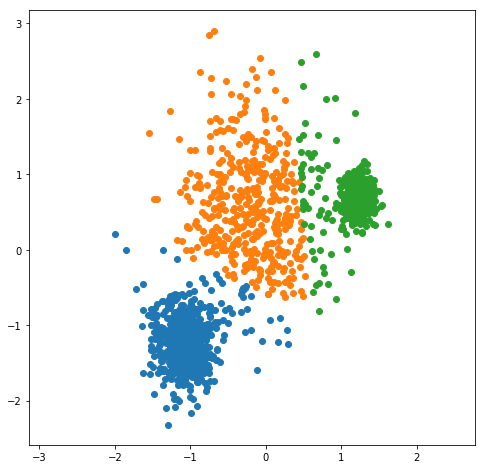

In [26]:
%matplotlib inline
# run k-means
ys = k_means_plus(X, k=3, n_iters=10)
# get final clustering
y = ys[-1]
# plot final clustering
plot_clustering(X, y)

#### 2. Dodać algorytm inicjalizacyjny *k-means++*, polegający na bardziej zaawansowanym wybieraniu startowych średnich:


1. Wybrać pierwszy punkt losowo z całego datasetu.
2. Dla każdego punktu z datasetu, policzyć jego odległość $D(x)$ od **najbliższego** wybranego już punktu.
3. Wybrać kolejny punkt startowy losując z datasetu ważąc prawdopodobieństwo każdego punktu kwadratem policznej odległości $D(x)^2$
4. Powtarzać punkty 2. i 3. aż do wybrania założonej liczby $k$.

*hint*: [`np.random.choice`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.choice.html)
  

In [54]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

In [86]:
@checker(run_tests=False)
def k_means_plus_plus(X: np.ndarray, k: int) -> List[np.ndarray]:
    means = X[np.random.choice(range(len(X)), size=1)] 
    while means.shape[0] < k:
        D = np.linalg.norm(X - means[0], axis=1).reshape(-1)  # 700
        for m in means:
            D_m = np.linalg.norm(X - m, axis=1).reshape(-1)  # 700
            D = np.min(np.append(D.reshape(-1, 1), D_m.reshape(-1, 1), axis=1), axis=1)
        np.append(means, X[np.random.choice(range(len(X)), size=1, p=softmax(D**2))])
        
    old_means = np.zeros(shape=(k, X.shape[1]))  # 3x2
    clusters = []
    while not np.isclose(old_means, means).all():
        distance = cdist(X, means)  # 700 x 3
        cluster = np.argmin(distance, axis=1)  # 700
        clusters.append(cluster)
        old_means = np.copy(means)
        for i in range(k):
            X_i = X[np.where(cluster == i)]
            if X_i.shape[0] > 0:
                means[i] = np.mean(X_i, axis=0)
            else:
                means[i] = X[np.random.choice(range(len(X)), size=1)]
    return clusters

In [ ]:
%matplotlib inline

# run k-means
ys = k_means_plus_plus(X, k=3)
# get final clustering
y = ys[-1]
# plot clustering
plot_clustering(X, y)

## Zadanie 4. Wizualizacja klastrowań (1 pkt.)

Proszę zaimplementować funkcję, której zadaniem jest odpalenie różnych klastrowań z pakietu `scikit-learn`. Funkcja powinna zwrócić listę list, gdzie w danym wierszu znajdują się wyniki klastrowania dla poszczególnego datasetu, a elementami wiersza są wyniki poszczególnej metody. 

Metody do zastosowania w tej kolejności: [`K-Means`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans), [`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN), [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering), [`GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture).

Proszę wszędzie gdzie to jest wymagane podać liczbę klastrów jako 3. W algorytmie `DBSCAN` zalecane podać parametr `eps = 0.3`.
Jako K-Means można oczywiście użyć swojej implementacji.

Użycie biblioteki sklearn na przykładzie algorytmu K-Means znajduje się poniżej. Dużo tutoriali do sk-learna można znaleźć [tutaj](https://scikit-learn.org/stable/tutorial/index.html).

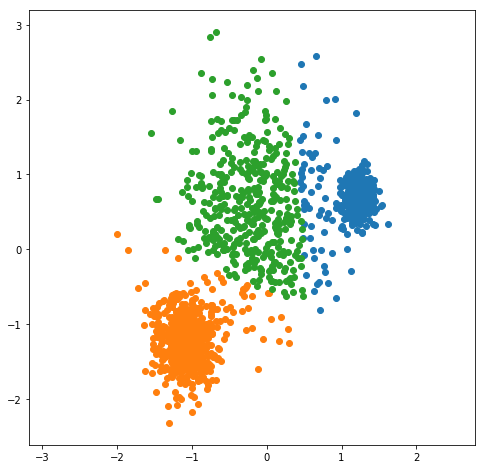

In [13]:
from sklearn.cluster import KMeans
from utils import get_clustering_data

# get some data
X = get_clustering_data()[3]

# initialize the model
model = KMeans(n_clusters=3)

# fit the model: this runs the actual algoritm
model.fit(X)

# get clustering for our 
y = model.predict(X)

# we can alose shothand the fit-predict if we want to predict the same that that we fit on
y = model.fit_predict(X)

# plot the results
plot_clustering(X, y)

In [88]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from utils import get_clustering_data

@checker(run_tests=True)
def get_clustering_results(datasets: List[np.ndarray]) -> List[List[np.ndarray]]:
    """Returns list of length len(datasets) with another list with clustering for each
       of the four methods: k-means, dbscan, agglomerative, gmm"""
    models = [KMeans(n_clusters=3), 
              DBSCAN(eps=0.3), 
              AgglomerativeClustering(n_clusters=3),
              GaussianMixture(n_components=3)]
    res = []
    for d in datasets:
        d_res = []
        for m in models:
            curr_res = m.fit_predict(d)
            d_res.append(curr_res)
        res.append(d_res)
    return res

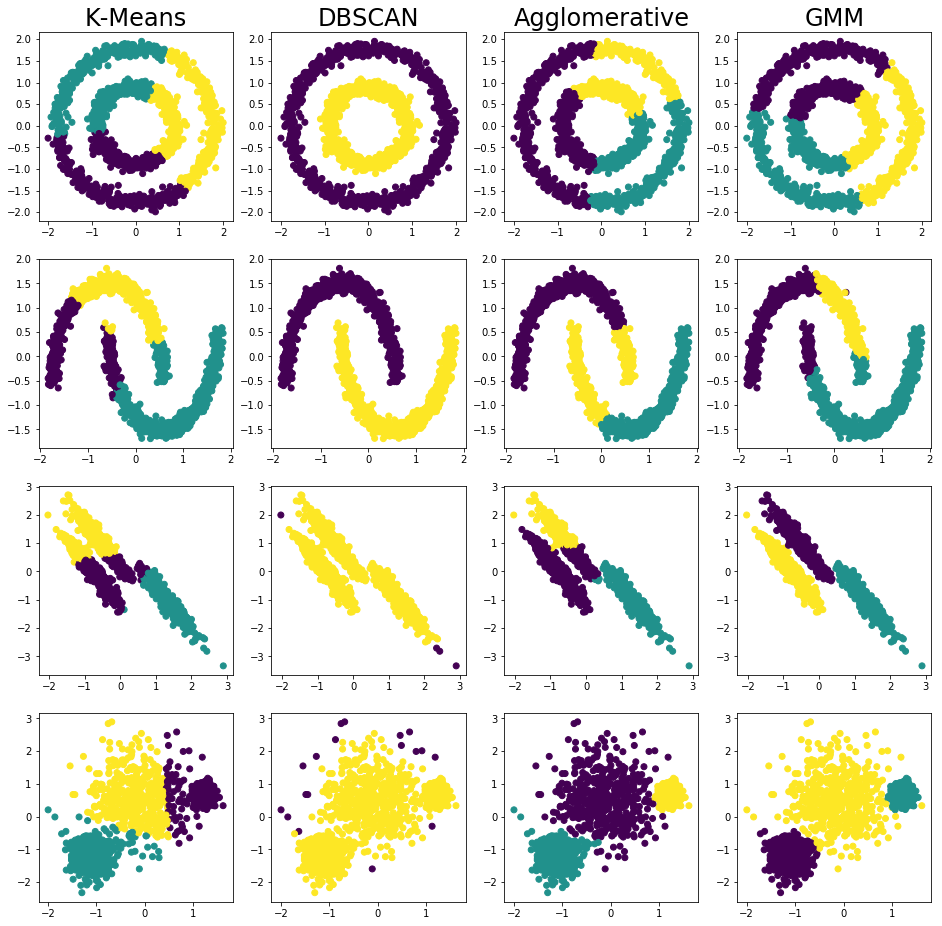

In [89]:
%matplotlib inline
from utils import plot_cluster_comparison

datasets = get_clustering_data()
results = get_clustering_results(datasets)

plot_cluster_comparison(datasets, results)